In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
sns.set(style="darkgrid")
sns.set(rc = {'figure.figsize':(15,8)})

In [ ]:
# install kaggle API so we can download data and submit predictions to the platform
!pip install kaggle --upgrade -q

In [ ]:
%%shell
mkdir -p /root/.kaggle
cp ./kaggle.json /root/.kaggle/
chmod 600 /root/.kaggle/kaggle.json # make the key invisible to other users 
kaggle competitions download -q house-prices-advanced-regression-techniques -p ./data/
unzip ./data/house-prices-advanced-regression-techniques.zip -d ./data/

Archive:  ./data/house-prices-advanced-regression-techniques.zip
replace ./data/data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/data_description.txt  
replace ./data/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/sample_submission.csv  
replace ./data/test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/test.csv         
replace ./data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: ./data/train.csv        


In [ ]:
train_data = pd.read_csv("./data/train.csv", index_col='Id')
test_data = pd.read_csv("./data/test.csv", index_col='Id')

In [ ]:
train = train_data.copy()
test = test_data.copy()

In [ ]:
train.shape, test.shape

((1460, 80), (1459, 79))

In [ ]:
train.SalePrice.isna().any()  # there is no NaN in target.

False

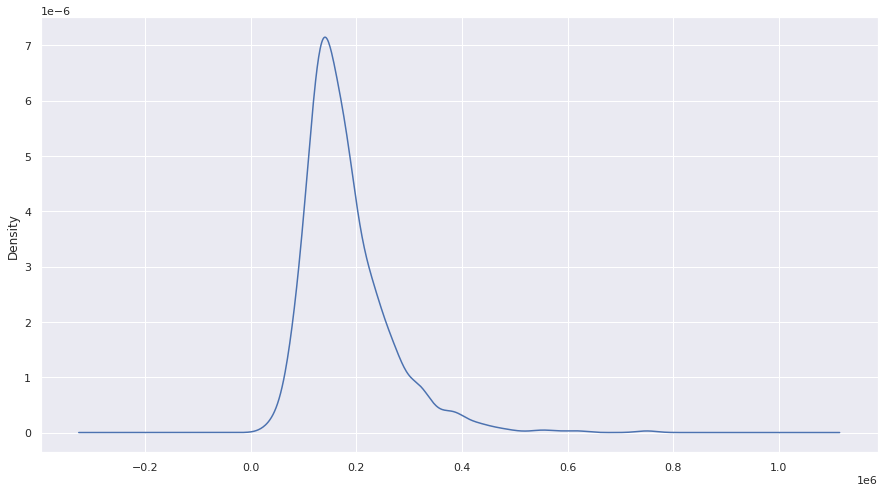

In [ ]:
train.SalePrice.plot.kde()

From here, we can see that saleprice  > 700k can be considered an outlier. 
So we drop them.

In [ ]:
train = train[train["SalePrice"] < 700000]

We can also quickly look at a detailed histogram:

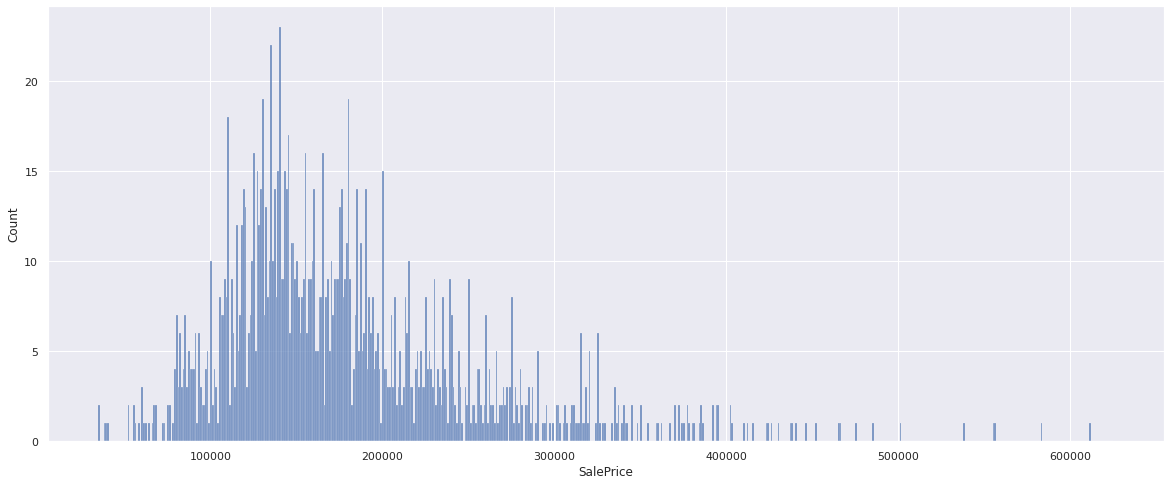

In [ ]:
plt.figure(figsize = (20,8))
bins = np.arange(train.SalePrice.min(),train.SalePrice.max(), 1000)
sns.histplot(train.SalePrice, bins=bins)

This is a very fine histogram indicating a highly discrete target. Note that target is positively skewed and an integer variable with repeating values.

In [ ]:
train.SalePrice.value_counts()

140000    20
135000    17
145000    14
155000    14
190000    13
          ..
202665     1
164900     1
208300     1
289000     1
147500     1
Name: SalePrice, Length: 661, dtype: int64

In [ ]:
train.dtypes.unique(), test.dtypes.unique()

(array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object),
 array([dtype('int64'), dtype('O'), dtype('float64')], dtype=object))

## Handling Missing Data

Let's find the features containing missing values. Here's the list of them:

In [ ]:
[(col, train[col].count()) for col in train 
                                 if train[col].count() < 1460]

[('MSSubClass', 1458),
 ('MSZoning', 1458),
 ('LotFrontage', 1199),
 ('LotArea', 1458),
 ('Street', 1458),
 ('Alley', 91),
 ('LotShape', 1458),
 ('LandContour', 1458),
 ('Utilities', 1458),
 ('LotConfig', 1458),
 ('LandSlope', 1458),
 ('Neighborhood', 1458),
 ('Condition1', 1458),
 ('Condition2', 1458),
 ('BldgType', 1458),
 ('HouseStyle', 1458),
 ('OverallQual', 1458),
 ('OverallCond', 1458),
 ('YearBuilt', 1458),
 ('YearRemodAdd', 1458),
 ('RoofStyle', 1458),
 ('RoofMatl', 1458),
 ('Exterior1st', 1458),
 ('Exterior2nd', 1458),
 ('MasVnrType', 1450),
 ('MasVnrArea', 1450),
 ('ExterQual', 1458),
 ('ExterCond', 1458),
 ('Foundation', 1458),
 ('BsmtQual', 1421),
 ('BsmtCond', 1421),
 ('BsmtExposure', 1420),
 ('BsmtFinType1', 1421),
 ('BsmtFinSF1', 1458),
 ('BsmtFinType2', 1420),
 ('BsmtFinSF2', 1458),
 ('BsmtUnfSF', 1458),
 ('TotalBsmtSF', 1458),
 ('Heating', 1458),
 ('HeatingQC', 1458),
 ('CentralAir', 1458),
 ('Electrical', 1457),
 ('1stFlrSF', 1458),
 ('2ndFlrSF', 1458),
 ('LowQualFin

We now separate categorical and numerical features with Nan values and study each:

In [ ]:
nan_features_cat = [cols for cols in train if train[cols].isna().any()
               and train[cols].dtypes == 'object' ]
nan_features_num = [cols for cols in train if train[cols].isna().any()
               and train[cols].dtypes in ['int64', 'float64'] ]

nan_features_cat_test = [cols for cols in test if test[cols].isna().any()
               and test[cols].dtypes == 'object' ]
nan_features_num_test = [cols for cols in test if test[cols].isna().any()
               and test[cols].dtypes in ['int64', 'float64'] ]

In [ ]:
train[nan_features_num].count()

LotFrontage    1199
MasVnrArea     1450
GarageYrBlt    1377
dtype: int64

We have three numeric features in the training data containing  NaN values, but some more in test data: 

In [ ]:
test[nan_features_num_test].count()

LotFrontage     1232
MasVnrArea      1444
BsmtFinSF1      1458
BsmtFinSF2      1458
BsmtUnfSF       1458
TotalBsmtSF     1458
BsmtFullBath    1457
BsmtHalfBath    1457
GarageYrBlt     1381
GarageCars      1458
GarageArea      1458
dtype: int64

And, categorical features in the training and test data containing  NaN values are

In [ ]:
train[nan_features_cat].count()

Alley             91
MasVnrType      1450
BsmtQual        1421
BsmtCond        1421
BsmtExposure    1420
BsmtFinType1    1421
BsmtFinType2    1420
Electrical      1457
FireplaceQu      768
GarageType      1377
GarageFinish    1377
GarageQual      1377
GarageCond      1377
PoolQC             6
Fence            280
MiscFeature       54
dtype: int64

In [ ]:
test[nan_features_cat_test].count()

MSZoning        1455
Alley            107
Utilities       1457
Exterior1st     1458
Exterior2nd     1458
MasVnrType      1443
BsmtQual        1415
BsmtCond        1414
BsmtExposure    1415
BsmtFinType1    1417
BsmtFinType2    1417
KitchenQual     1458
Functional      1457
FireplaceQu      729
GarageType      1383
GarageFinish    1381
GarageQual      1381
GarageCond      1381
PoolQC             3
Fence            290
MiscFeature       51
SaleType        1458
dtype: int64

As it is seen, all categorical variables in training and test sets include NaN values. However, the NaN values might not necessarily represent missing values. For example: 

In [ ]:
(train[train['GarageCond'].isna() & 
      train['GarageQual'].isna()]['GarageArea'] == 0).all()

True

which means 'GarageCond' and 'GarageQual' take NaN values *only* where there is no garage! these observations are not considered missing. So we replace them by approriate values:

In [ ]:
train.loc[pd.Index(train.GarageArea == 0),
      ['GarageType',
      'GarageFinish',
      'GarageQual',
      'GarageCond',]] = 'NoGarage'
test.loc[pd.Index(test.GarageArea == 0),
      ['GarageType',
      'GarageFinish',
      'GarageQual',
      'GarageCond',]] = 'NoGarage'

Similarly, we do the same for other features:

In [ ]:
train.loc[pd.Index(train.PoolArea == 0),
      ['PoolQC']] = 'NoPool'
test.loc[pd.Index(test.PoolArea == 0),
      ['PoolQC']] = 'NoPool'

Similarly:

In [ ]:
(train[train['BsmtQual'].isna()]['TotalBsmtSF'] == 0).all()

True

In [ ]:
train.loc[pd.Index(train.TotalBsmtSF == 0),
                ['BsmtQual', 
                 'BsmtCond',
                 'BsmtFinType1',
                 'BsmtFinType2',
                 'BsmtExposure',
                ]] = 'NoBsmt'
test.loc[pd.Index(test.TotalBsmtSF == 0),
                ['BsmtQual', 
                 'BsmtCond',
                 'BsmtFinType1',
                 'BsmtFinType2',
                 'BsmtExposure',
                ]] = 'NoBsmt'

We now check again for any possible missing value not captured so far. The following shows that there is missing values left for _BsmtExposure_ :

In [ ]:
(train[train['BsmtExposure'].isna()]['TotalBsmtSF'] == 0).all()

False

and that is observation #949 only:

In [ ]:
train[train['BsmtExposure'].isna()]['TotalBsmtSF']

Id
949    936
Name: TotalBsmtSF, dtype: int64

This is the only real missing record. We substitute it by 'No',
which is the most frequent value for 'No Exposure'.

In [ ]:
train['BsmtExposure'].value_counts()

No        953
Av        220
Gd        133
Mn        114
NoBsmt     37
Name: BsmtExposure, dtype: int64

In [ ]:
train.loc[949,'BsmtExposure'] = 'No' 

Three more missing values in test data:

In [ ]:
test[test['BsmtExposure'].isna()][['BsmtExposure',
                                       'BsmtCond',
                                       'OverallQual']]

,BsmtExposure,BsmtCond,OverallQual
Id,,,
1488,NaN,TA,8
2121,NaN,NaN,4
2349,NaN,TA,5


We just plug in some values based on *OverallQual*. Had replaced them with the most freq values, we would have been fine:

In [ ]:
test.loc[1488, 'BsmtExposure'] = 'Av'
test.loc[2121, 'BsmtExposure'] = 'Mn'
test.loc[2349, 'BsmtExposure'] = 'Mn'

Carrying on:

In [ ]:
train[train['BsmtFinType2'].isna()][['BsmtFinSF2',
                             'BsmtUnfSF',
                             'BsmtFinSF1',
                             'TotalBsmtSF',
                             'BsmtFinType2',
                             'BsmtFinType1',
                             'BsmtQual']]

,BsmtFinSF2,BsmtUnfSF,BsmtFinSF1,TotalBsmtSF,BsmtFinType2,BsmtFinType1,BsmtQual
Id,,,,,,,
333,479,1603,1124,3206,NaN,GLQ,Gd


One single missing value only; sub in the most frequent value for the feature:

In [ ]:
train['BsmtFinType2'].fillna('Rec', inplace=True) # Most freq value is 'Rec'

Next, check the test data:

In [ ]:
test['BsmtFinType1'].count()

1458

In [ ]:
test['BsmtFinType2'].count()

1458

There is one more missing value in _BsmtFinType1_ and _BsmtFinType2_ that should be filled:

In [ ]:
# Replace by the most freq values
test['BsmtFinType1'].fillna('Unf', inplace=True)
test['BsmtFinType2'].fillna('Unf', inplace=True)

Similarly,

In [ ]:
test['BsmtQual'].count()

1456

In [ ]:
test[test['BsmtQual'].isna()][['BsmtQual',
                                  'BsmtCond',
                                  'OverallQual']]

,BsmtQual,BsmtCond,OverallQual
Id,,,
2121,NaN,NaN,4
2218,NaN,Fa,4
2219,NaN,TA,4


In [ ]:
test.loc[2121, 'BsmtQual'] = 'TA'
test.loc[2218, 'BsmtQual'] = 'Fa'
test.loc[2219, 'BsmtQual'] = 'Fa'
test.loc[2121, ['BsmtQual', 'BsmtCond']] = 'Fa'

In [ ]:
test[test['BsmtCond'].isna()][['BsmtQual',
                                  'BsmtCond',
                                  'OverallQual']]

,BsmtQual,BsmtCond,OverallQual
Id,,,
2041,Gd,NaN,8
2186,TA,NaN,6
2525,TA,NaN,5


In [ ]:
test.loc[2041, 'BsmtCond'] = 'Gd'
test.loc[2186, 'BsmtCond'] = 'TA'
test.loc[2525, 'BsmtCond'] = 'TA'

We continue to other features:

In [ ]:
train.loc[pd.Index(train.Fireplaces == 0),
      ['FireplaceQu']] = 'NoFirePlace'
test.loc[pd.Index(test.Fireplaces == 0),
      ['FireplaceQu']] = 'NoFirePlace'

In [ ]:
train.loc[pd.Index(train.MasVnrArea == 0),
      ['MasVnrType']] = 'None'
test.loc[pd.Index(test.MasVnrArea == 0),
      ['MasVnrType']] = 'None'

Next is 'Electerical' feature with one single missing record replaced by the most freq value:

In [ ]:
train['Electrical'].fillna('SBrkr', inplace=True)

According to data description, NaN value for feature "Fence" represents "No Fence": 

In [ ]:
train['Fence'].fillna('No Fence', inplace=True)
test['Fence'].fillna('No Fence', inplace=True)

And, similarly

In [ ]:
train['PoolQC'].fillna('No Pool', inplace=True)
test['PoolQC'].fillna('No Pool', inplace=True)

Now we check the counts again:

In [ ]:
train[nan_features_cat].count()

Alley             91
MasVnrType      1450
BsmtQual        1458
BsmtCond        1458
BsmtExposure    1458
BsmtFinType1    1458
BsmtFinType2    1458
Electrical      1458
FireplaceQu     1458
GarageType      1458
GarageFinish    1458
GarageQual      1458
GarageCond      1458
PoolQC          1458
Fence           1458
MiscFeature       54
dtype: int64

Only three left:

In [ ]:
train['MasVnrType'].unique()

array(['BrkFace', 'None', 'Stone', 'BrkCmn', nan], dtype=object)

In [ ]:
train['MasVnrType'].value_counts()

None       865
BrkFace    443
Stone      127
BrkCmn      15
Name: MasVnrType, dtype: int64

In [ ]:
train[(train['MasVnrType'].isna())][['MasVnrType', 'MasVnrArea']]

,MasVnrType,MasVnrArea
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN


In [ ]:
train['MasVnrArea'].fillna(0, inplace=True) # Most freq value
train['MasVnrType'].fillna('None', inplace=True) # Most freq value

There are some more numerics features with missing values:

In [ ]:
[((train[col].isna()).sum(), col) for col  in nan_features_num]

[(259, 'LotFrontage'), (0, 'MasVnrArea'), (81, 'GarageYrBlt')]

In the case of *GarageYrBlt* , the NaN values are due to non-existance of garage:

In [ ]:
(train[train['GarageYrBlt'].isna()]['GarageArea'] == 0).all()

True

In [ ]:
(train[train['GarageArea'] == 0]['GarageYrBlt']).all()

True

In this case, we choose to take 'YearBuilt' value as appropriate values for 'GarageYrBlt' because for most of the houses, these values are equal. In this case, 'GarageYrBlt' does not privide distinctive insight about the gragre. 

In [ ]:
#X['GarageYrBlt'].fillna(X['GarageYrBlt'].mean(), inplace=True) # missing Garage Blt is set 1982. 

In [ ]:
train.loc[pd.Index(train.GarageYrBlt.isna()),'GarageYrBlt'] = \
train.loc[pd.Index(train.GarageYrBlt.isna()),'YearBuilt']

This is not true for the test data:

In [ ]:
(test[test['GarageYrBlt'].isna()]['GarageArea'] == 0).all()

False

In [ ]:
(test[test['GarageYrBlt'].isna()]['GarageArea'] == 0).sum()

76

Out of the total:

In [ ]:
test['GarageYrBlt'].isna().sum()

78

We take the risk for those 2 observations and move on to:

In [ ]:
test.loc[pd.Index(test['GarageYrBlt'].isna()),
           'GarageYrBlt'] = \
test.loc[pd.Index(test['GarageYrBlt'].isna()),
       'YearBuilt']   

There is only one missing value for the following features:

In [ ]:
test['GarageCars'].fillna(train['GarageCars'].median(), inplace=True)
test['GarageArea'].fillna(train['GarageArea'].median(), inplace=True)
test['BsmtFinSF1'].fillna(train['BsmtFinSF1'].median(), inplace=True)
test['BsmtFinSF2'].fillna(train['BsmtFinSF2'].median(), inplace=True)
test['BsmtUnfSF'].fillna(train['BsmtUnfSF'].median(), inplace=True)
test['TotalBsmtSF'].fillna(train['TotalBsmtSF'].median(), inplace=True)
test['BsmtFullBath'].fillna(train['BsmtFullBath'].median(), inplace=True)
test['BsmtHalfBath'].fillna(train['BsmtHalfBath'].median(), inplace=True)


The next feature is *LotFrontage* with 259 missing values of which  226 are Single Family Detched homes in the training data. About the same ratio holds for test data.

In [ ]:
train[train['LotFrontage'].isna()]['BldgType'].value_counts()

1Fam      226
TwnhsE     22
Duplex      5
Twnhs       3
2fmCon      3
Name: BldgType, dtype: int64

In [ ]:
test['LotFrontage'].isna().sum()

227

In [ ]:
test[test['LotFrontage'].isna()]['BldgType'].value_counts()

1Fam      197
TwnhsE     16
Duplex     12
Twnhs       2
Name: BldgType, dtype: int64

In [ ]:
m = train[train['BldgType'] == '1Fam']['LotFrontage'].median() # 226 of missing values are Single Family Detched homes.
m

71.0

In [ ]:
train['LotFrontage'].fillna(m, inplace=True) # missing 'LotFrontage' is set 75. 

In [ ]:
test['LotFrontage'].fillna(m, inplace=True)

Diving deeper into the test data:

In [ ]:
test['MasVnrArea'].isna().sum()

15

In [ ]:
test.loc[pd.Index(test.MasVnrType.isna()),
                       'MasVnrType'] = 'None' # Most freq value
test.loc[pd.Index(test.MasVnrArea.isna()),
                       'MasVnrArea'] = 0

In [ ]:
test.loc[pd.Index(test['Exterior1st'].isna()),
                           'Exterior1st'] = 'VinylSd' # Most freq value
test.loc[pd.Index(test['Exterior2nd'].isna()),
                           'Exterior2nd'] = 'VinylSd'

In [ ]:
test['MSZoning'].fillna('RL', inplace=True) 

_KitchenQual_ has a single missing value in the test data:

In [ ]:
test[test['KitchenQual'].isna()][['KitchenQual',
                                  'BsmtCond',
                                  'OverallQual']]

,KitchenQual,BsmtCond,OverallQual
Id,,,
1556,NaN,Fa,5


In [ ]:
test.loc[1556, 'KitchenQual'] = 'Fa' # most freq value

Next feature is _Functional_ :

In [ ]:
test[test['Functional'].isna()][['Functional',
                                  #'BsmtCond',
                                  'OverallQual']]

,Functional,OverallQual
Id,,
2217,NaN,1
2474,NaN,4


In [ ]:
test['Functional'].fillna('Min1', inplace=True)

Now, Garage-related features:

In [ ]:
test['GarageFinish'].isna().sum()

2

In [ ]:
test['GarageFinish'].fillna('Unf', inplace=True)  # most freq value

In [ ]:
test['GarageQual'].isna().sum()

2

In [ ]:
test['GarageQual'].fillna('TA', inplace=True) # most freq value

In [ ]:
test['GarageCond'].isna().sum()

2

In [ ]:
test['GarageCond'].fillna('TA', inplace=True) # most freq value

And, finally *SaleType* : 

In [ ]:
test['SaleType'].isna().sum()

1

In [ ]:
test['SaleType'].fillna('WD', inplace=True)

Now, let's check to see what is left:

In [ ]:
test[nan_features_cat_test].count()

MSZoning        1459
Alley            107
Utilities       1457
Exterior1st     1459
Exterior2nd     1459
MasVnrType      1459
BsmtQual        1459
BsmtCond        1459
BsmtExposure    1459
BsmtFinType1    1459
BsmtFinType2    1459
KitchenQual     1459
Functional      1459
FireplaceQu     1459
GarageType      1459
GarageFinish    1459
GarageQual      1459
GarageCond      1459
PoolQC          1459
Fence           1459
MiscFeature       51
SaleType        1459
dtype: int64

Some features have very low varience, which is not helpful when it comes to making predictions:

In [ ]:
test['Utilities'].value_counts()

AllPub    1457
Name: Utilities, dtype: int64

We have chosen to drop some low-variance features:

In [ ]:
train.drop(['Alley', 'Street', 'Utilities', 'MiscFeature',
           'PoolQC', 'CentralAir', 'PoolArea', 'LowQualFinSF',
       ], axis=1, inplace=True)
test.drop(['Alley', 'Street', 'Utilities', 'PoolQC',
             'MiscFeature', 'CentralAir', 'PoolArea', 
             'LowQualFinSF',], axis=1, inplace=True)

We have filled all missing data in both training and test data:

In [ ]:
train.isna().any().any()

False

In [ ]:
test.isna().any().any()

False

## Categorical encoding

To encode our categorical features, we will use a type of *target enconding*. Before implementing that, we put aside some features such as *Exterior1st* and *Exterior2nd*, which take the same set of values but but the values could be different for a given observation.

In [ ]:
cat = train.columns[train.dtypes == 'object']
cat = list(cat)

cat.remove('Exterior1st')
cat.remove('Exterior2nd')

cat.remove('Condition1')
cat.remove('Condition2')

cat.remove('BsmtFinType1')
cat.remove('BsmtFinType2')

In [ ]:
train[cat].isna().any().any(),  test[cat].isna().any().any()

(False, False)

The following function does the target encoding:

In [ ]:
def ordinal_map(col):
    c = train.groupby(col)[['SalePrice']].\
    apply(lambda x:  x.median()).\
    sort_values(by='SalePrice').reset_index().drop(columns=['SalePrice'])
    d = {str(v):i for i,v in zip(np.arange(1, len(c) + 1),c.values.ravel())}
    return d



Apply the function to the categorical features below:

In [ ]:
for col in cat:
    gategories = ordinal_map(col)
    train.loc[:, col] = train[[col]].applymap(gategories.get)
    test.loc[:, col] = test[[col]].applymap(gategories.get)


We now treat the special features with same value separately to ensure a unified encoding:

In [ ]:
gategories = ordinal_map('Condition1')
train.loc[:, 'Condition1'] = train[['Condition1']].applymap(gategories.get)
test.loc[:, 'Condition1'] = test[['Condition1']].applymap(gategories.get)
train.loc[:, 'Condition2'] = train[['Condition2']].applymap(gategories.get)
test.loc[:, 'Condition2'] = test[['Condition2']].applymap(gategories.get)

In [ ]:
gategories = ordinal_map('BsmtFinType1')
train.loc[:, 'BsmtFinType1'] = train[['BsmtFinType1']].applymap(gategories.get)
test.loc[:, 'BsmtFinType1'] = test[['BsmtFinType1']].applymap(gategories.get)
train.loc[:, 'BsmtFinType2'] = train[['BsmtFinType2']].applymap(gategories.get)
test.loc[:, 'BsmtFinType2'] = test[['BsmtFinType2']].applymap(gategories.get)

We noticed some descrepancies in spelling values for features *Exterior1st* and *Exterior2nd*. Here we try to fix this first before we apply the encoding:

In [ ]:
train.loc[pd.Index(train['Exterior2nd'] == 'Wd Shng'),'Exterior2nd'] = 'WdShing'
test.loc[pd.Index(test['Exterior2nd'] == 'Wd Shng'),'Exterior2nd'] = 'WdShing'

train.loc[pd.Index(train['Exterior2nd'] == 'Brk Cmn'),'Exterior2nd'] = 'BrkComm'
test.loc[pd.Index(test['Exterior2nd'] == 'Brk Cmn'),'Exterior2nd'] = 'BrkComm'

train.loc[pd.Index(train['Exterior2nd'] == 'CmentBd'), 'Exterior2nd'] = 'CemntBd'
test.loc[pd.Index(test['Exterior2nd'] == 'CmentBd'), 'Exterior2nd'] = 'CemntBd'


In [ ]:
gategories = ordinal_map('Exterior1st')
train.loc[:, 'Exterior1st'] = train[['Exterior1st']].applymap(gategories.get)
test.loc[:, 'Exterior1st'] = test[['Exterior1st']].applymap(gategories.get)
train.loc[:, 'Exterior2nd'] = train[['Exterior2nd']].applymap(gategories.get)
test.loc[:, 'Exterior2nd'] = test[['Exterior2nd']].applymap(gategories.get)


There is one single value "Other" for feature 'Exterior2nd' that is not taken by 'Exterior1st' so it doesnt transfer from 'Exterior1st' to 'Exterior2nd' by our encoding transformer. We encode it manually to a new value.

In [ ]:
train.loc[596, 'Exterior2nd'] = 16 # This was equal to 'Other'.

Now let's look at the correlation matrix:

In [ ]:
corr = train.corr()
corr.shape

(72, 72)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


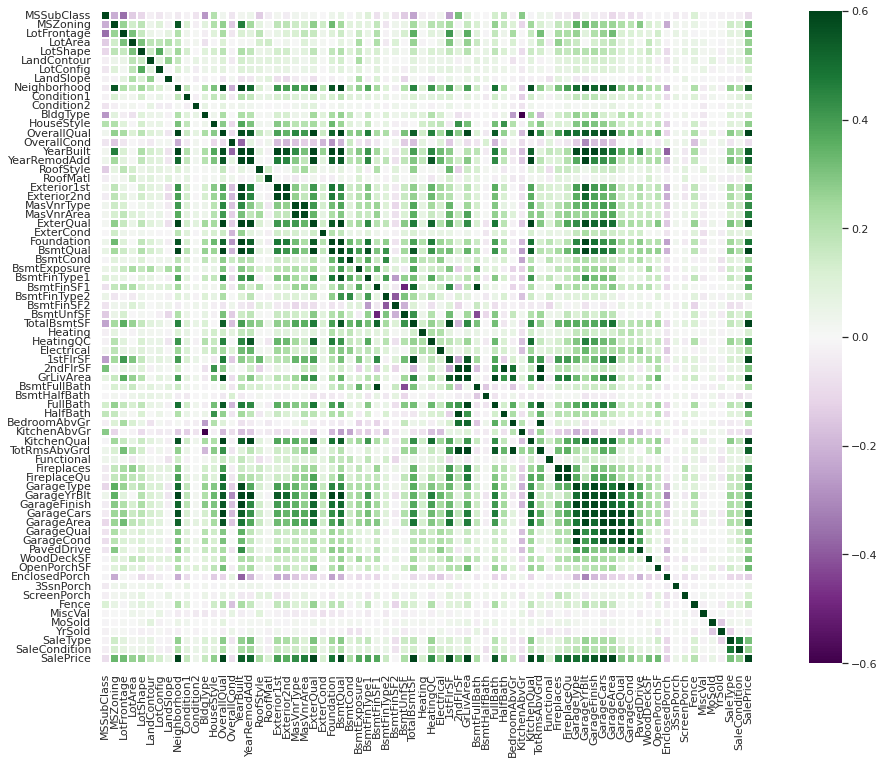

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(20, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap='PRGn', vmax=.6,
            vmin=-.6,
            center=0,
            square=True, 
            linewidths=1.5,
            yticklabels=True,
            cbar_kws={"shrink": 1})

plt.show()

In [ ]:
sorted([(col, train[col].corr(train['SalePrice'])) for col in train],
         key=lambda x:x[1], reverse=True)

[('SalePrice', 1.0),
 ('OverallQual', 0.7959979433422552),
 ('Neighborhood', 0.7063822053585854),
 ('GrLivArea', 0.6935568683204664),
 ('ExterQual', 0.6904603059223258),
 ('KitchenQual', 0.6635611111020472),
 ('GarageCars', 0.6486191462502874),
 ('GarageArea', 0.6311053941742572),
 ('BsmtQual', 0.628338716779297),
 ('TotalBsmtSF', 0.6087690478075725),
 ('1stFlrSF', 0.5994373998465587),
 ('FullBath', 0.557557914025909),
 ('GarageFinish', 0.5557980710973717),
 ('YearBuilt', 0.5345647792121003),
 ('TotRmsAbvGrd', 0.5334104631515402),
 ('FireplaceQu', 0.5333501281526298),
 ('YearRemodAdd', 0.5208085960636876),
 ('GarageYrBlt', 0.5199530242671478),
 ('GarageType', 0.5014297749852579),
 ('Foundation', 0.48651667154899636),
 ('MasVnrArea', 0.4683960648670007),
 ('Fireplaces', 0.4638314984599794),
 ('MasVnrType', 0.4351626082847456),
 ('HeatingQC', 0.43470784329764356),
 ('Exterior1st', 0.39301304229020545),
 ('BsmtFinType1', 0.3852376468928622),
 ('BsmtFinSF1', 0.37339416631467576),
 ('BsmtEx

## Features Engineering and Analysis 

In this section, I study the interaction between different features and the target variable. I will employ various ways of extracting and creating new features that are potentially helpful
for different model, specially tree-based models. 

0.36006737538342176
0.39301304229020545


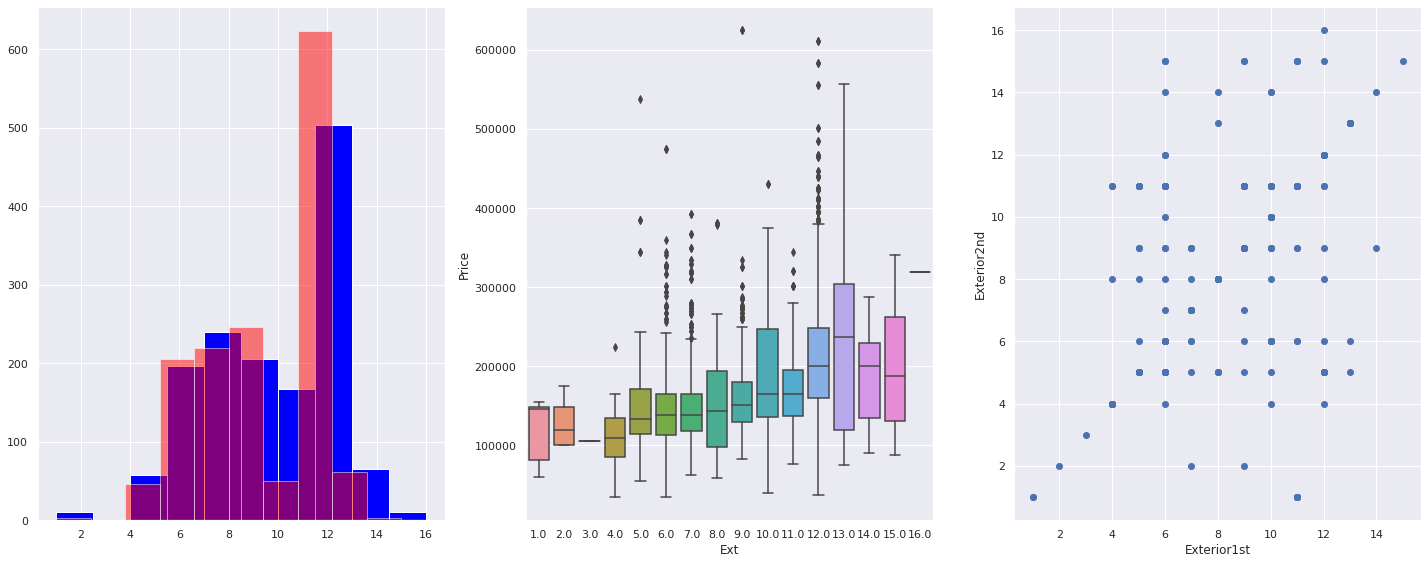

In [ ]:
fig = plt.figure(figsize=(20,8))
ax1 = fig.add_subplot(131)
ax1.hist(train['Exterior2nd'], color='blue')
ax1.hist(train['Exterior1st'], color = 'red', alpha=0.5)
print((train['Exterior2nd']).corr(train['SalePrice']))
print((train['Exterior1st']).corr(train['SalePrice']))



ax2 = fig.add_subplot(132)
df1 = pd.DataFrame(train[['Exterior1st', 'SalePrice']].values, columns=['Ext','Price']).assign(types="Ext1st")
df2 = pd.DataFrame(train[['Exterior2nd', 'SalePrice']].values, columns=['Ext','Price']).assign(types="Ext2nd")
df = pd.concat([df1, df2])
sns.boxplot(x='Ext', y='Price', data=df, ax=ax2)

ax3 = fig.add_subplot(133)
ax3.scatter(train['Exterior1st'], train['Exterior2nd'])
plt.xlabel('Exterior1st')
plt.ylabel('Exterior2nd')


plt.tight_layout()
plt.show()

#(train['GarageArea']+ train['TotalBsmtSF']).corr(train['SalePrice'])

For how many records are 'Exterior1st' and 'Exterior2nd' equal?

In [ ]:
(train['Exterior2nd'] == train['Exterior1st']).sum()/1460

0.9054794520547945

Over 90% of times. 

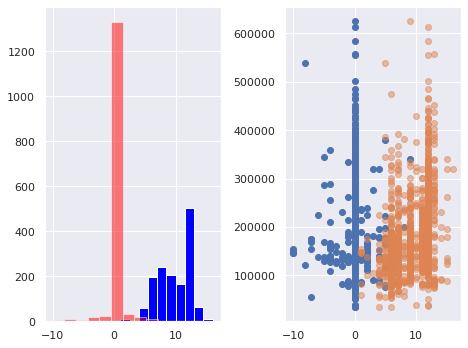

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(131)
ax1.hist(train['Exterior2nd'], color='blue')
ax1.hist(train['Exterior2nd'] - train['Exterior1st'], color = 'red', alpha=0.5)



ax2 = fig.add_subplot(132)
ax2.scatter(train['Exterior2nd'] - train['Exterior1st'], train['SalePrice'])
ax2.scatter((train['Exterior2nd']), train['SalePrice'], alpha=0.5)


plt.tight_layout()
plt.show()

The difference of two features provide smaller entropy so we substitue it for one of the features:

In [ ]:
train['Exterior2nd'] = train['Exterior2nd'] - train['Exterior1st']
test['Exterior2nd'] = test['Exterior2nd'] - test['Exterior1st']

Similarly

In [ ]:
train['Condition2'] = train['Condition2'] - train['Condition1']
test['Condition2'] = test['Condition2'] - test['Condition1']

## Numerical feature analysis

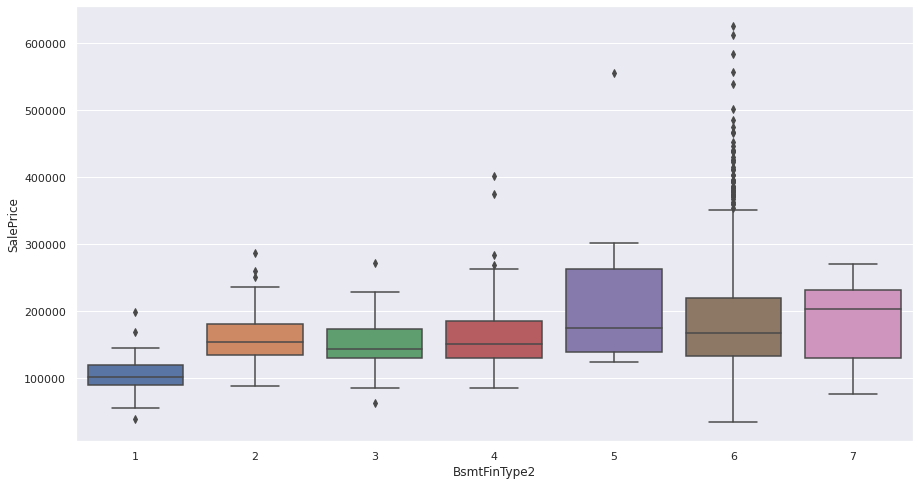

In [ ]:
sns.boxplot(x=train['BsmtFinType2'], y=train['SalePrice'])

'BsmtUnfSF' is dependent on 'BsmtFinSF1', 'BsmtFinSF1', 'TotalBsmtSF'. So we drop it.

In [ ]:
train.drop('BsmtUnfSF', axis=1, inplace=True)
test.drop('BsmtUnfSF', axis=1, inplace=True)

0.37339416631467576
0.45895419061583503


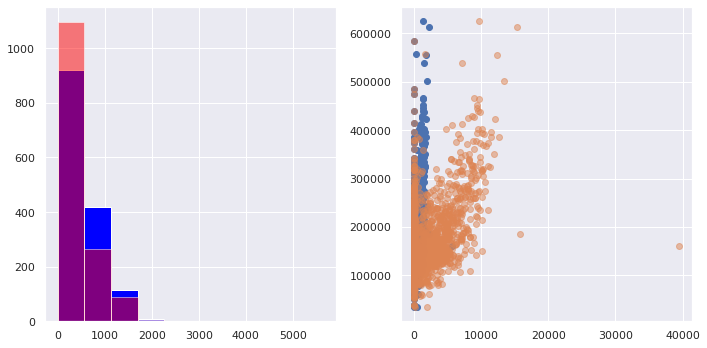

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(train['BsmtFinSF1'], color='blue')
ax1.hist(train['BsmtFinSF1']*train['BsmtFinType1']/7, color = 'red', alpha=0.5)
print((train['BsmtFinSF1']).corr(train['SalePrice']))
print((train['BsmtFinSF1']*train['BsmtFinType1']).corr(train['SalePrice']))

ax2 = fig.add_subplot(122)
ax2.scatter(train['BsmtFinSF1'], train['SalePrice'])
ax2.scatter(train['BsmtFinSF1']*train['BsmtFinType1'], train['SalePrice'], alpha=0.5)

plt.tight_layout()
plt.show()

This change have slightly improved both entropy and correlation.

In [ ]:
train.loc[:,'BsmtFinSF1'] = train['BsmtFinSF1']*train['BsmtFinType1']
train.loc[:,'BsmtFinSF2'] = train['BsmtFinSF2']*train['BsmtFinType2']

In [ ]:
test.loc[:,'BsmtFinSF1'] = test['BsmtFinSF1']*test['BsmtFinType1']
test.loc[:,'BsmtFinSF2'] = test['BsmtFinSF2']*test['BsmtFinType2']

Now we look at a new feature made from area related features and compare it to the strongest area-base feature, which is *GrLivArea* :

In [ ]:
new_feature = train['TotalBsmtSF']+train['1stFlrSF']+train['2ndFlrSF']

0.6935568683204664
0.7729484756383517


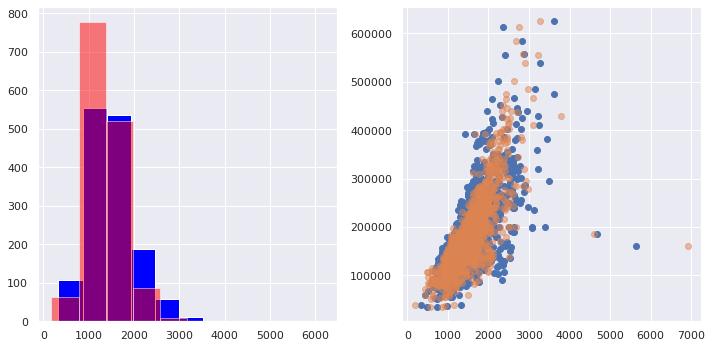

In [ ]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax1.hist(train['GrLivArea'], color='blue')
ax1.hist(new_feature/1.9, color = 'red', alpha=0.5)
print((train['GrLivArea']).corr(train['SalePrice']))
print((new_feature/1.7).corr(train['SalePrice']))



ax2 = fig.add_subplot(122)
ax2.scatter(train['GrLivArea'], train['SalePrice'])
ax2.scatter((new_feature)/1.7, train['SalePrice'], alpha=0.5)


plt.tight_layout()
plt.show()



62.0

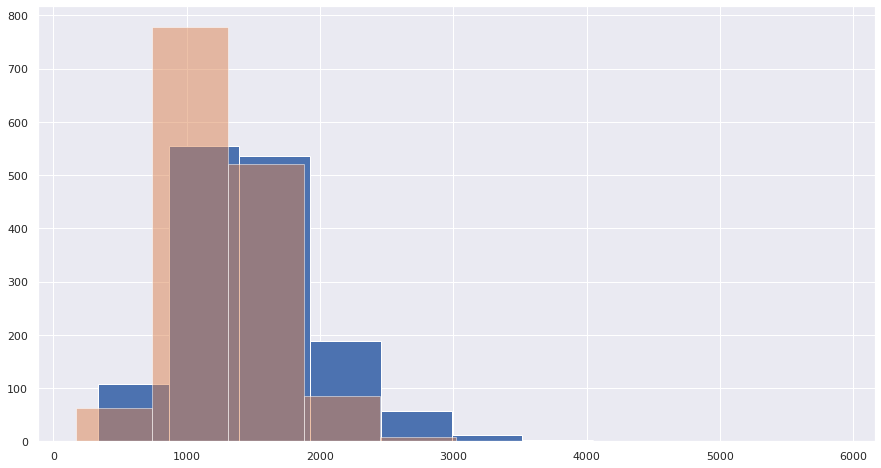

In [ ]:
plt.hist(train['GrLivArea'])[0]
plt.hist(new_feature/2,alpha=0.5)[0][0]

The new feature is called 'LivArea'.

In [ ]:
train['LivArea'] = train['TotalBsmtSF'] + train['1stFlrSF'] + train['2ndFlrSF']
test['LivArea'] = test['TotalBsmtSF'] + test['1stFlrSF'] + test['2ndFlrSF']

A parametric t-test confirms that the new feature has statistically mean. 

In [ ]:
stats.ttest_ind(train['GrLivArea'], train['LivArea'])

Ttest_indResult(statistic=-41.869804154959546, pvalue=2.209596132806974e-300)

A non-parametric test confirms the same as well.

In [ ]:
stats.wilcoxon(train['GrLivArea'], train['LivArea'])

WilcoxonResult(statistic=1.0, pvalue=5.223293690678138e-234)

Also we try to improve the entropy in the following:

In [ ]:
(train['GrLivArea'] >= train['1stFlrSF']).all()

True

In [ ]:
(train['1stFlrSF'] >= train['2ndFlrSF']).sum()

1323

In [ ]:
train.loc[:, '2ndFlrSF'] = train['1stFlrSF'] - train['2ndFlrSF']
test.loc[:, '2ndFlrSF'] = test['1stFlrSF'] - test['2ndFlrSF']

In [ ]:
train.loc[:, '1stFlrSF'] = train['GrLivArea'] - train['1stFlrSF']
test.loc[:, '1stFlrSF'] = test['GrLivArea'] - test['1stFlrSF']

Now feature '2ndFlrSF' provides very low correlation with SalePrice. So we drop it!

In [ ]:
train.drop('2ndFlrSF', axis=1, inplace=True)
test.drop('2ndFlrSF', axis=1, inplace=True)

The following new feature could help understand the shape of the land in most cases:

In [ ]:
train['LotLength'] = train['LotArea'] / train['LotFrontage']
test['LotLength'] = test['LotArea'] / test['LotFrontage']

Next we compare three types differences for year-base features:

In [ ]:
(train['YearRemodAdd'] - train['YearBuilt']).corr(train['SalePrice'])

-0.22018177297410393

In [ ]:
(train['YearRemodAdd'] - train['YrSold']).corr(train['SalePrice'])

0.5224711666481365

In [ ]:
(train['YearBuilt'] - train['YrSold']).corr(train['SalePrice'])

0.5347873889571613

array([1047.,   72.,  117.,   67.,   49.,   34.,   38.,   21.,    8.,
          5.])

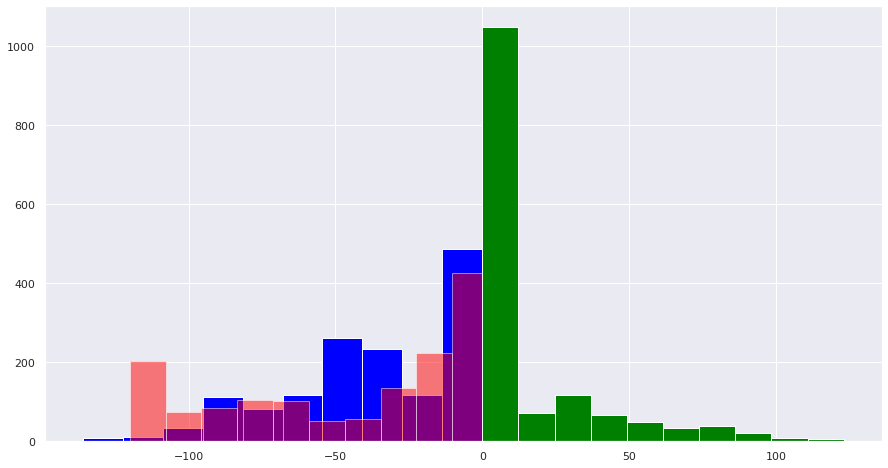

In [ ]:
plt.hist(train['YearBuilt'] - train['YrSold'], color='blue')[0]
plt.hist((train['YearRemodAdd'] - train['YrSold'])*2, color='red', alpha=0.5)[0]
plt.hist(train['YearRemodAdd'] - train['YearBuilt'], color='green')[0]

The difference between 'YearBuilt' and 'YrSold' provides a btter baclance for correlation and a lower variance distribution.

In [ ]:
train['Age'] = train['YrSold'] - train['YearBuilt']
test['Age'] = test['YrSold'] - test['YearBuilt']

The difference between 'YearRemodAdd' and 'YrSold' shows very strong correlation and similar disribution to 'YearRemodAdd'. Thus it probably will not imporve our model much in presence of 'YearRemodAdd'. 

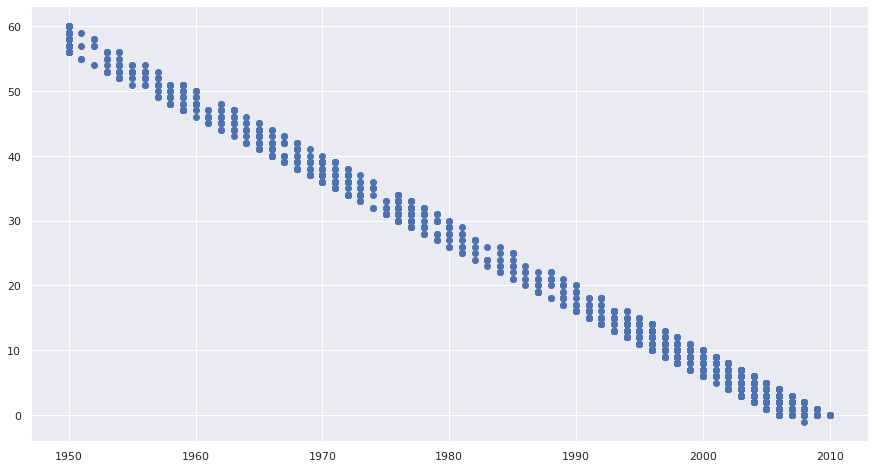

In [ ]:
plt.scatter(train['YearRemodAdd'], train['YrSold'] - train['YearRemodAdd'])

For the same reason as mentioned before, we add the following new feature:

0.5978070558023879
0.5334104631515402


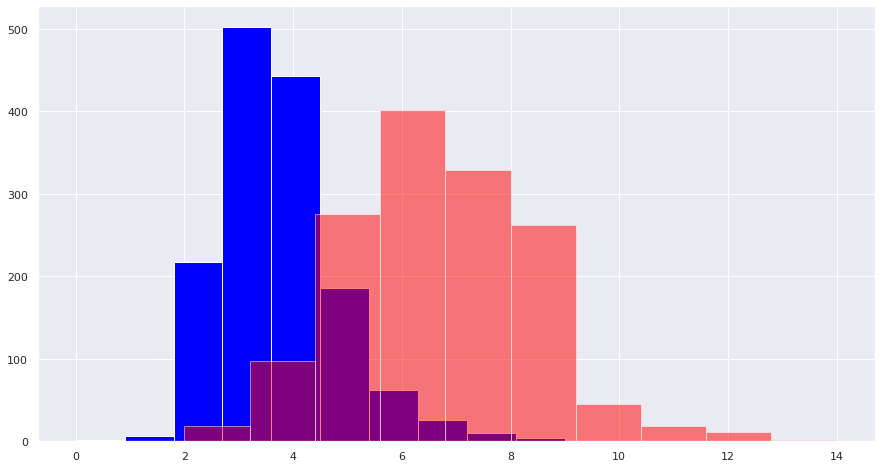

In [ ]:
plt.hist(train['TotRmsAbvGrd'] - train['BedroomAbvGr'], color='blue')[0]
plt.hist(train['TotRmsAbvGrd'], color='red', alpha=0.5)[0]

print((train['TotRmsAbvGrd'] - train['BedroomAbvGr']).corr(train['SalePrice']))
print((train['TotRmsAbvGrd']).corr(train['SalePrice']))

In [ ]:
train['RmsAbvGr'] = train['TotRmsAbvGrd'] - train['BedroomAbvGr']
test['RmsAbvGr'] = test['TotRmsAbvGrd'] - test['BedroomAbvGr']

and drop one of the componenets:

In [ ]:
train.drop('TotRmsAbvGrd', axis=1, inplace=True)
test.drop('TotRmsAbvGrd', axis=1, inplace=True)

In fact, 'TotRmsAbvGrd' was relaced by the new feature.

Another new feature is related to area:

In [ ]:
train['Area'] = train['GrLivArea'] + train['GarageArea']
test['Area'] = test['GrLivArea'] + test['GarageArea']

In [ ]:
train['Area'].corr(train['SalePrice']), train['Area'].corr(train['GrLivArea'])

(0.7649494848531481, 0.9559191783033546)

In [ ]:
stats.ttest_ind(train['GrLivArea'], train['Area'])

Ttest_indResult(statistic=-21.90218342552923, pvalue=1.4541610484879093e-98)

array([ 62., 778., 521.,  86.,   8.,   1.,   1.,   0.,   0.,   1.])

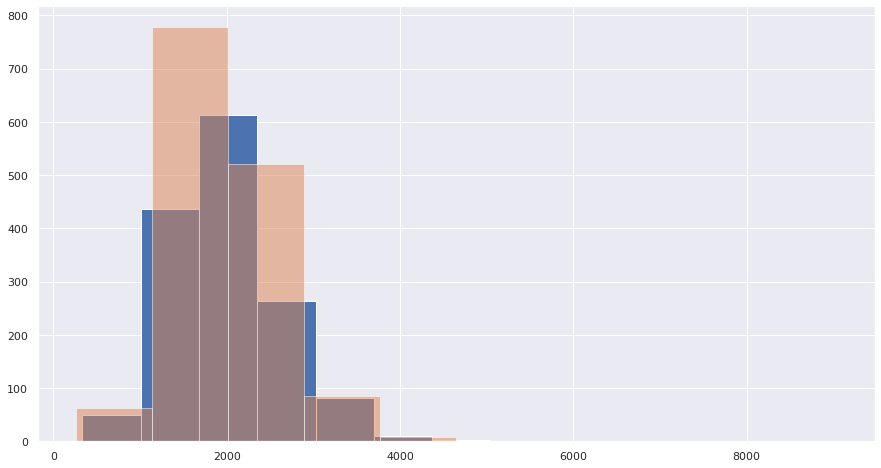

In [ ]:
plt.hist((train['Area']))[0]
plt.hist((train['LivArea'])/1.3, alpha=0.5)[0]

In [ ]:
corr = train.corr()
corr.shape

(74, 74)

In [ ]:
sorted([(col, train[col].corr(train['SalePrice'])) for col in train.columns],
         key=lambda x:x[1], reverse=True)


[('SalePrice', 1.0),
 ('OverallQual', 0.7959979433422552),
 ('LivArea', 0.7729484756383516),
 ('Area', 0.7649494848531481),
 ('Neighborhood', 0.7063822053585854),
 ('GrLivArea', 0.6935568683204664),
 ('ExterQual', 0.6904603059223258),
 ('KitchenQual', 0.6635611111020472),
 ('GarageCars', 0.6486191462502874),
 ('GarageArea', 0.6311053941742572),
 ('BsmtQual', 0.628338716779297),
 ('TotalBsmtSF', 0.6087690478075725),
 ('RmsAbvGr', 0.5978070558023879),
 ('FullBath', 0.557557914025909),
 ('GarageFinish', 0.5557980710973717),
 ('YearBuilt', 0.5345647792121003),
 ('FireplaceQu', 0.5333501281526298),
 ('YearRemodAdd', 0.5208085960636876),
 ('GarageYrBlt', 0.5199530242671478),
 ('GarageType', 0.5014297749852579),
 ('Foundation', 0.48651667154899636),
 ('MasVnrArea', 0.4683960648670007),
 ('Fireplaces', 0.4638314984599794),
 ('BsmtFinSF1', 0.45895419061583503),
 ('MasVnrType', 0.4351626082847456),
 ('HeatingQC', 0.43470784329764356),
 ('Exterior1st', 0.39301304229020545),
 ('BsmtFinType1', 0.38

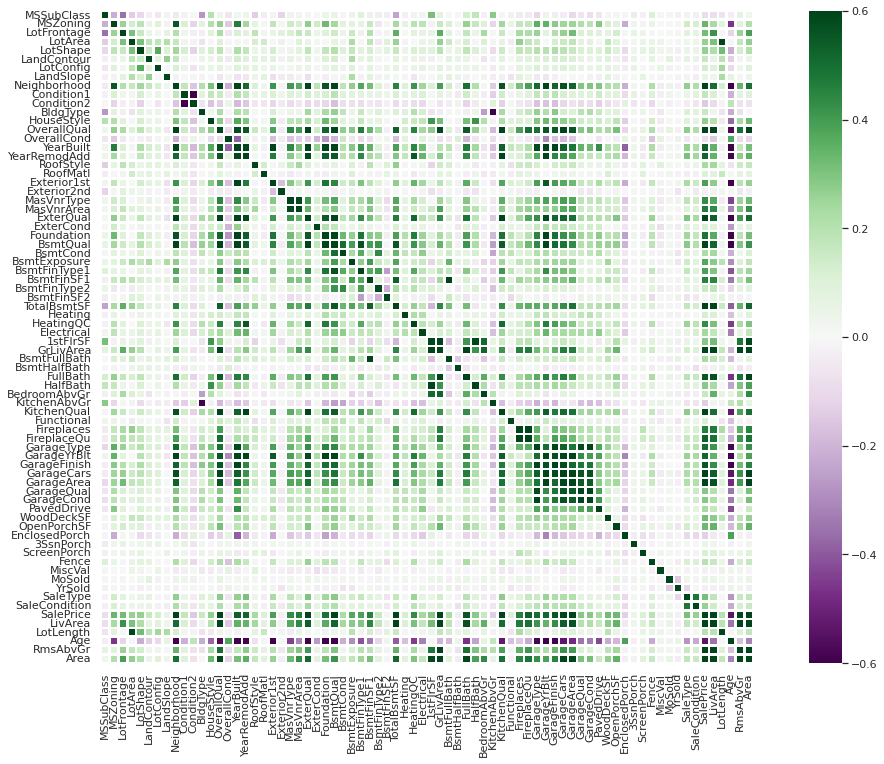

In [ ]:
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(20, 12))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap="PRGn", vmax=.6,
            vmin=-.6,
            center=0,
            square=True, 
            linewidths=1.5,
            yticklabels=True,
            #annot=True,
            cbar_kws={"shrink": 1})

plt.show()

## Exploring

In [ ]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor, NeighborhoodComponentsAnalysis
from sklearn import manifold
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score

In [ ]:
X = train.drop('SalePrice', axis=1)
y = train.SalePrice

In [ ]:
random_state = 0
n_components = 2

Reduce dimension to 2 with PCA, LPCA, LDA, NCA first to see how well data is caraterized visually. We insclude LDA as an option for our embedding (LDA is a classifier) although we have a theoretically continuous response variable. On the other hand, it is reasonable to consider our response (price of a house) as a discrete variable in this data as the number of unique values is 661 out of 1460 records.


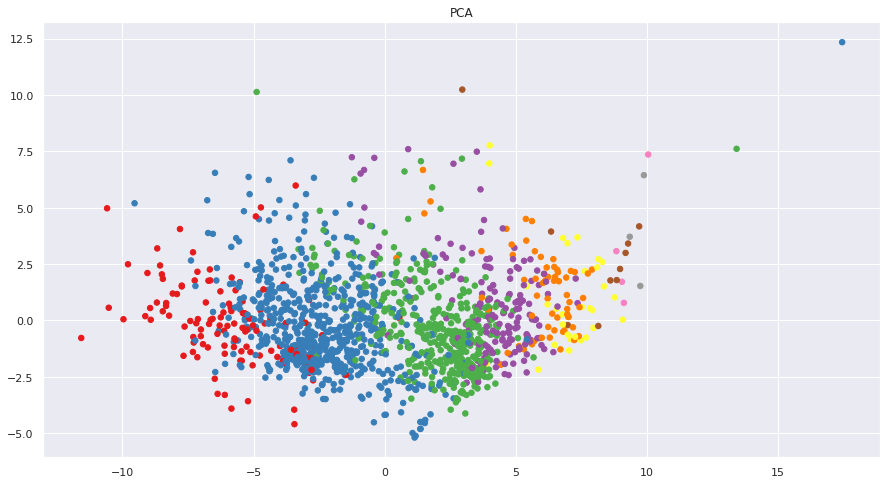

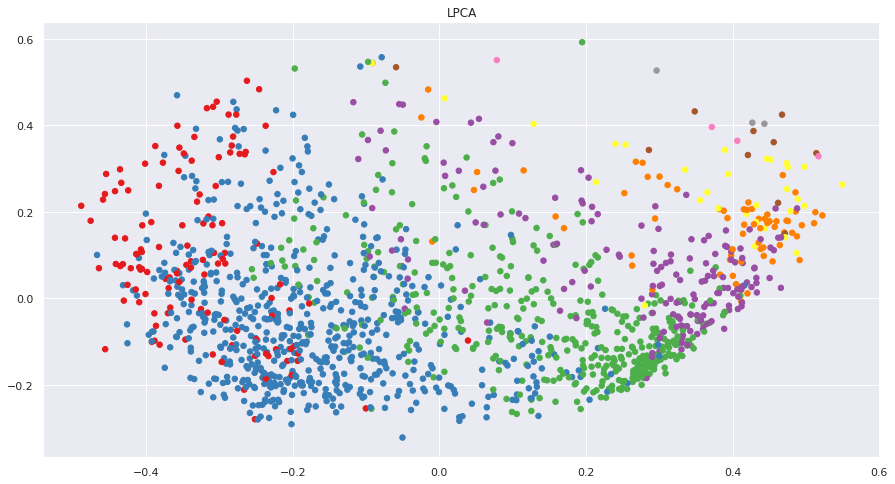

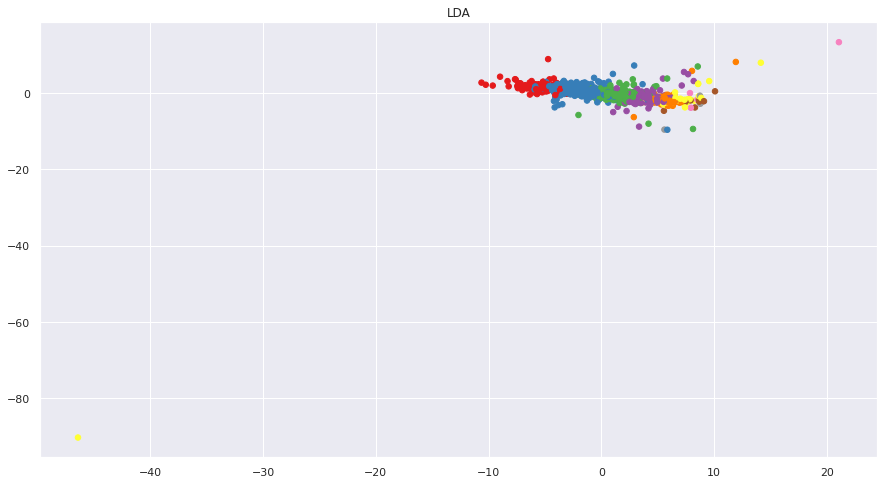

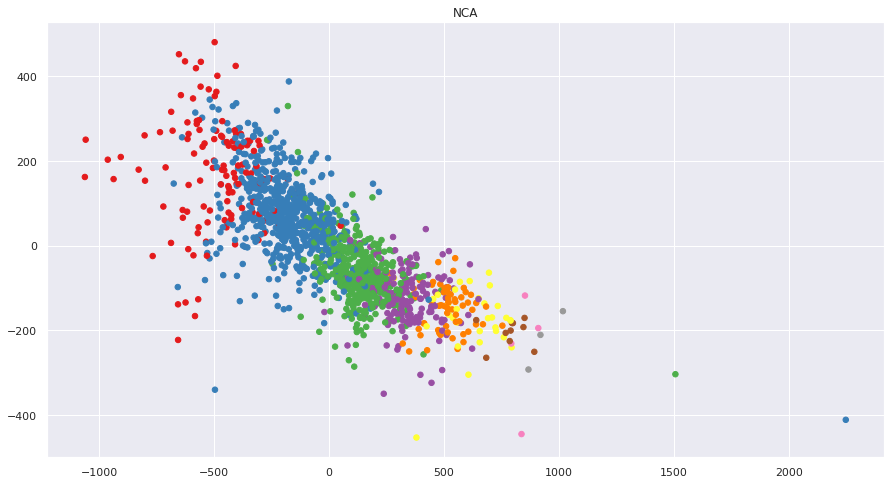

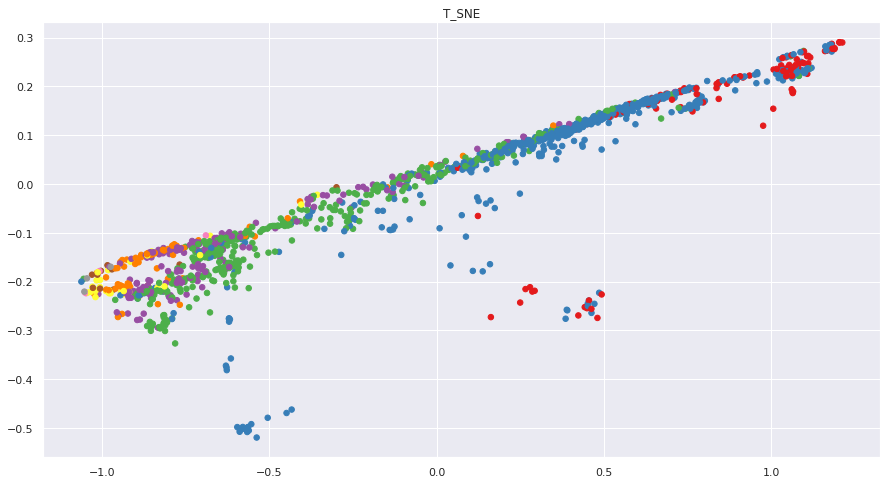

In [ ]:
pca = make_pipeline(StandardScaler(), 
                    PCA(n_components=n_components, random_state=random_state))

kpca = make_pipeline(StandardScaler(), 
                     KernelPCA(n_components=n_components, kernel='rbf', gamma=0.005, random_state=random_state))

lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=n_components))

nca = make_pipeline(StandardScaler(),
    NeighborhoodComponentsAnalysis(n_components=n_components, random_state=random_state),
)

t_sne = make_pipeline(StandardScaler(),
      manifold.TSNE(n_components=n_components, learning_rate="auto", perplexity=11, n_iter=250, init="random", random_state=random_state,)
)

dim_reduction_methods = [("PCA", pca), ("LPCA", kpca), ("LDA", lda), ("NCA", nca), ("T_SNE", t_sne)]


for i, (name, model) in enumerate(dim_reduction_methods):
    # Embed the data set in  n_components dimensions using the fitted model
    X_embedded = model.fit_transform(X, y)

    fig = plt.figure()
    plt.scatter(x=X_embedded[:, 0], y=X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.title(f'{name}')

The best score is achieved by LDA using KNN. To see this, we split data into half for training and test subsets. Then fit a KNN regressor on the embedded data to choose the highest score. After choosing LDA as our embedding, we train a KNN regressor that achieve better score for various embedding dimensions. It sounds dim=4 and n_neighbors=6 works fine.   

In [ ]:
n_neighbors = 6
n_components = 4

We pick LDA for our embedding. It is reasonable to consider our response (price of a house) as a discrete variable! as it takes finite number of values. In this data, the number of unique values is 661 out of 1460 records. This is why it still makes sense to use it in this context even though LDA is a classifier. Instead of fitting LDA with 661 classes, we bin data into bucket bins of width 5000$ so we have a smaller number of classes and probably more accurate embedding. This way, our class numbers reduce to 119 classes

In [ ]:
target = train.SalePrice
bins = np.arange(target.min(),target.max(), 5000)
ind_5000 = np.digitize(target.values, bins)
print(len(bins))

119


In [ ]:
X_train = train.drop(['SalePrice'], axis=1)
y_train = train.SalePrice

In [ ]:
# train LDA with 119 classes
lda = make_pipeline(StandardScaler(), LinearDiscriminantAnalysis(n_components=n_components))
lda.fit(X_train, ind_5000)
lda.classes_

array([  1,   2,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,
        41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,
        54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,
        67,  68,  69,  70,  71,  72,  73,  74,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  87,  89,  91,  94, 101, 105, 110, 116, 119])

In [ ]:
# get the embedded data into n_componenets dimensional space
X_transformed = lda.transform(X_train)
test_transformed = lda.transform(test)

In [ ]:
# train a KNN regressor whose prediction will be used as a new feature
knn = KNeighborsRegressor(n_neighbors=n_neighbors)
knn.fit(X_transformed, y_train)

KNeighborsRegressor(n_neighbors=6)

In [ ]:
# add KNN predictions as a new feature
X_train = pd.concat([X_train, pd.DataFrame(knn.predict(X_transformed), columns=['KNN'], index=X_train.index)],
                    axis=1)
X_test = pd.concat([test, pd.DataFrame(knn.predict(test_transformed), columns=['KNN'], index=test.index)],
                   axis=1)

Here is the residual plot for our KNN, which indicates a reasonable and balanced fit.

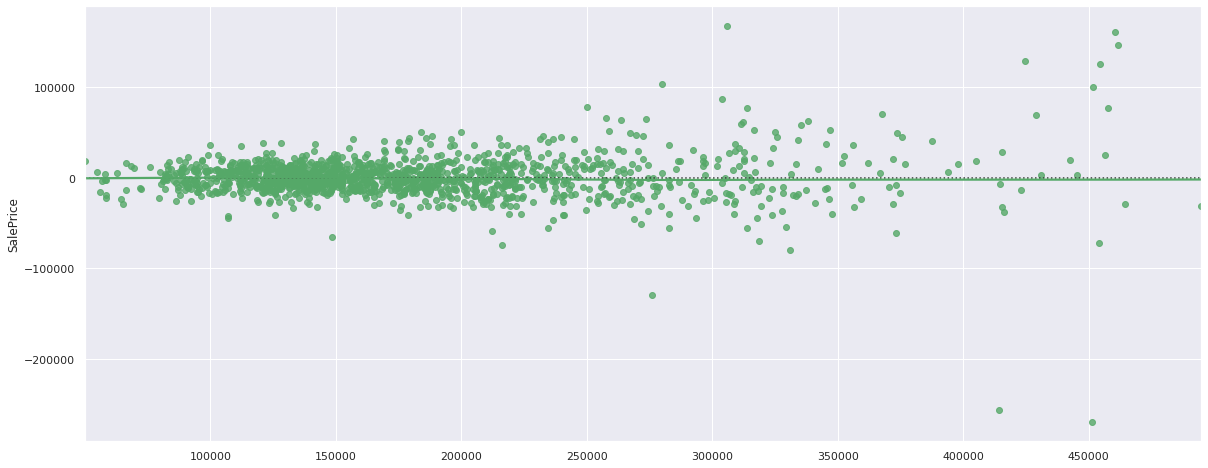

In [ ]:
fig = plt.figure(figsize=(20,8))
sns.residplot(x=knn.predict(X_transformed), y=y_train, lowess=True, color="g", robust=True)

## Train XGBoost model:

In [ ]:
X_train.shape, X_test.shape

((1458, 74), (1459, 74))

Now let us train a XGBoost Model. We set the parameters as follow:

In [ ]:
# install the latest version of XGBoost
!pip uninstall xgboost
!pip install xgboost

Found existing installation: xgboost 0.90
Uninstalling xgboost-0.90:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/xgboost-0.90.dist-info/*
    /usr/local/lib/python3.7/dist-packages/xgboost/*
    /usr/local/xgboost/libxgboost.so
Proceed (y/n)? y
  Successfully uninstalled xgboost-0.90
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 192.9 MB 75 kB/s 


In [ ]:
import xgboost as xgb
xgb.__version__

'1.6.1'




Covert the data into XGBoost data structure: 

In [ ]:
dtrain = xgb.DMatrix(data=X_train, label=y_train)

In [ ]:
params = {
          'eval_metric': ['rmsle', 'mae'],
          'learning_rate': 0.03,
          'max_depth': 5,
          'n_jobs': -1, 
          'alpha': 1,
          'verbosity': 0,
          'min_child_weight': 1,
          'subsample': 0.6,
          'colsample_bytree': 0.3,
          'colsample_bylevel': 1,
          'tree_method': 'hist',
          'seed': 0,
          'disable_default_eval_metric': 1,
          'num_parallel_tree': 20, # Boosted forest for more robust prediction
}

Use cross validation to pick the best hyperparameters. Let'see how the model is doing:

In [ ]:
xgb.cv(params, 
       dtrain,
       num_boost_round=1000,
       nfold=5,
       stratified=False,
       seed=0,
       shuffle=True,
).drop([
        'train-rmsle-std',
        'train-mae-std',
        'test-rmsle-std',
        'test-mae-std',
], axis=1).tail(1)

,train-rmsle-mean,train-mae-mean,test-rmsle-mean,test-mae-mean
999,0.018473,1997.420944,0.108955,12828.113755


Now that we are happy with the parameters, we finally train our model on the entire data:

In [ ]:
bst = xgb.train(
                params, 
                dtrain,
                1000,
                maximize=False,
                verbose_eval =False,
)

And finally, we make predictions on our test data:

In [ ]:
bst.predict(xgb.DMatrix(X_test)) # The Best Prediction

array([124289.38, 162859.28, 188128.56, ..., 171141.3 , 119304.6 ,
       206421.48], dtype=float32)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


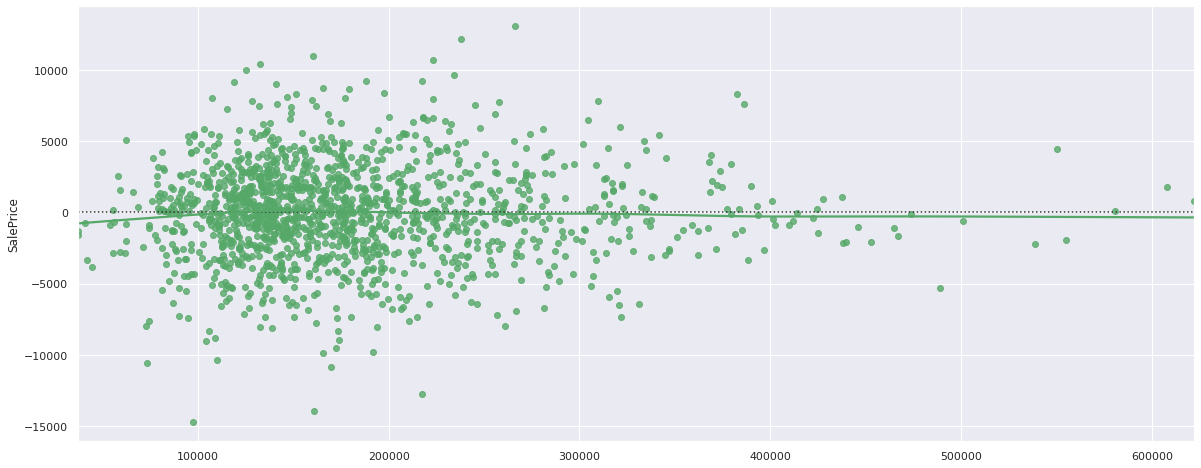

In [ ]:
fig = plt.figure(figsize=(20,8))
sns.residplot(bst.predict(xgb.DMatrix(X_train)), y=y_train, lowess=True, color="g", robust=True)

If we want to submit the predictions for evaluations by Kaggle.com, we save them in a *csv* format file:

In [ ]:
prediction = bst.predict(xgb.DMatrix(X_test))
Submit = pd.DataFrame({'Id':X_test.index, 'SalePrice': prediction}, index=X_test.index)
Submit.to_csv("submition.csv", index=False)

In [ ]:
!kaggle competitions submit -c house-prices-advanced-regression-techniques -f /content/submition.csv -m 'S1'

100% 21.2k/21.2k [00:05<00:00, 4.20kB/s]
Successfully submitted to House Prices - Advanced Regression Techniques

Here is feature impartance in view of our model:

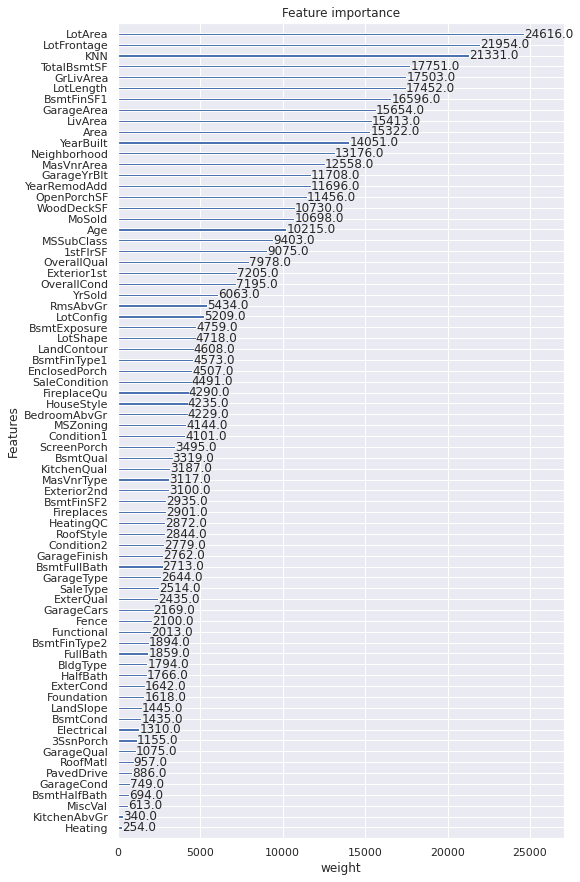

In [ ]:
fig = plt.figure(figsize=(8, 15))
ax = fig.add_subplot()
xgb.plot_importance(bst, 
                    ax=ax, 
                    height=0.2, 
                    xlim=None, 
                    ylim=None, 
                    title='Feature importance', 
                    xlabel='weight', 
                    ylabel='Features', 
                    importance_type='weight', 
                    max_num_features=None, 
                    grid=True, 
                    show_values=True, 
)

plt.show()